<a href="https://colab.research.google.com/github/Diego-CB/DS-Proyecto/blob/main/proyecto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [159]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from collections import Counter
from wordcloud import WordCloud

In [160]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [161]:

id = '1kzPayZj888s0RkHlxYHGXzHwdb63fEYH'
url = 'https://drive.google.com/uc?id=' + id
data = pd.read_csv(url)

In [162]:
data.shape

(36765, 5)

In [163]:
data.columns

Index(['discourse_id', 'essay_id', 'discourse_text', 'discourse_type',
       'discourse_effectiveness'],
      dtype='object')

In [164]:
data.dtypes

discourse_id               object
essay_id                   object
discourse_text             object
discourse_type             object
discourse_effectiveness    object
dtype: object

In [165]:
data.head()

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate


In [166]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36765 entries, 0 to 36764
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   discourse_id             36765 non-null  object
 1   essay_id                 36765 non-null  object
 2   discourse_text           36765 non-null  object
 3   discourse_type           36765 non-null  object
 4   discourse_effectiveness  36765 non-null  object
dtypes: object(5)
memory usage: 1.4+ MB


In [167]:
data.describe()

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
count,36765,36765,36765,36765,36765
unique,36765,4191,36691,7,3
top,0013cc385424,91B1F82B2CF1,Summer projects should be student-designed,Evidence,Adequate
freq,1,23,14,12105,20977


In [168]:
data.isnull().sum()

discourse_id               0
essay_id                   0
discourse_text             0
discourse_type             0
discourse_effectiveness    0
dtype: int64

In [169]:
data.corr()

<ipython-input-169-c44ded798807>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr()


""


In [170]:
columns = data.columns
numeric_data = data._get_numeric_data().columns

categorical_data = set(columns) - set(numeric_data)
print("-> Columnas con valores numericos \n ",numeric_data ,'\n')
print("-> Columnas con valores categoricos\n ",categorical_data)

-> Columnas con valores numericos 
  Index([], dtype='object') 

-> Columnas con valores categoricos
  {'essay_id', 'discourse_effectiveness', 'discourse_text', 'discourse_id', 'discourse_type'}


Como todo el dataset es texto pues se busca trabajar con natural language processing tomaremos una ruta distinta para explorar los datos.

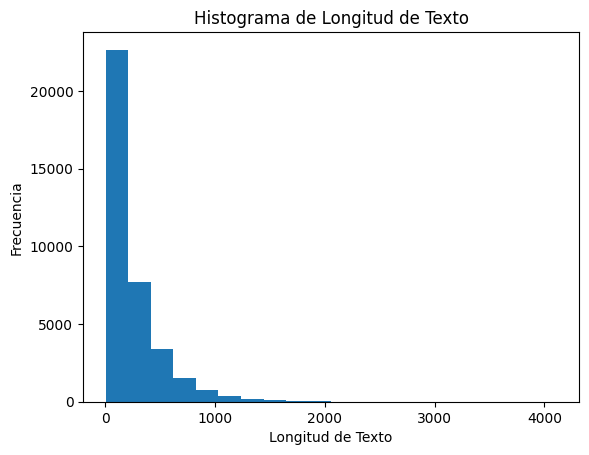

In [171]:
data['text_lenght'] = data['discourse_text'].apply(len)
plt.hist(data['text_lenght'], bins=20)  # Cambia el valor de bins según tus preferencias
plt.title('Histograma de Longitud de Texto')
plt.xlabel('Longitud de Texto')
plt.ylabel('Frecuencia')
plt.show()

In [172]:
texto_combinado = ' '.join(data['discourse_text'])
vocabulario = sorted(set(texto_combinado))

letras = [c for c in vocabulario if c.isalpha()]
numeros = [c for c in vocabulario if c.isdigit()]
especiales = [c for c in vocabulario if c not in string.ascii_letters + string.digits]

# Imprimir las categorías y sus contenidos
print("Letters:", ''.join(letras))
print("Numbers:", ''.join(numeros))
print("Especial Characters:", ''.join(especiales))
print("Vocab size:",len(vocabulario))

Letters: ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyzÂÃËåþ
Numbers: 0123456789
Especial Characters: 
 !"#$%&'()*+,-./:;=>?@[\]^_`{|}~ ¢¨®°´ÂÃËåþ
Vocab size: 113


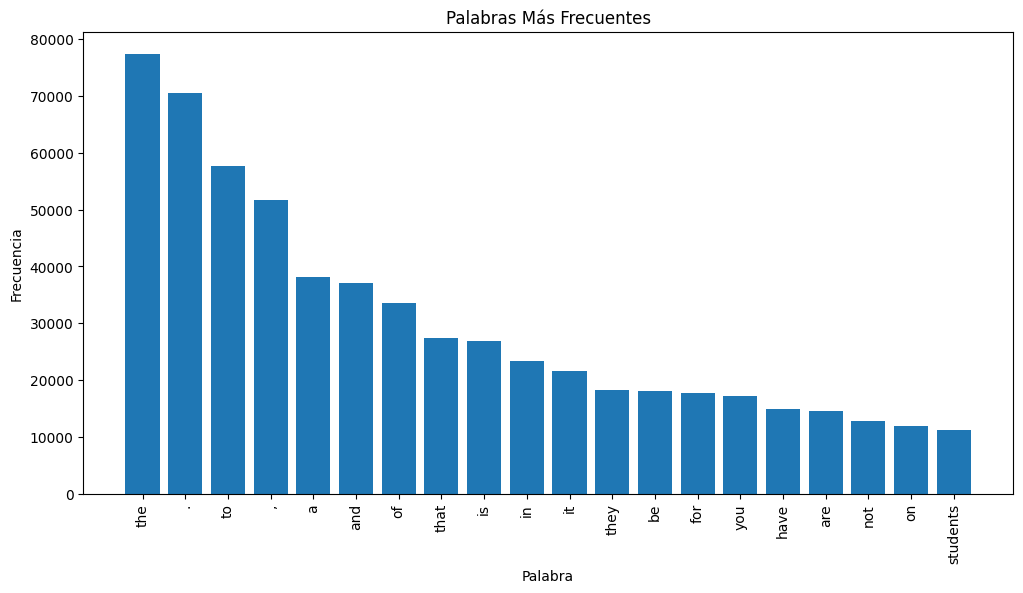

In [173]:
data['tokens'] = data['discourse_text'].apply(word_tokenize)
word_frequency = Counter(word for words in data['tokens'] for word in words)
most_common_words = word_frequency.most_common(20)  # Cambia el número según tus preferencias

# Separar las palabras y las frecuencias en listas separadas
words, frequencies = zip(*most_common_words)

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(words, frequencies)
plt.title('Palabras Más Frecuentes')
plt.xlabel('Palabra')
plt.ylabel('Frecuencia')
plt.xticks(rotation=90)  # Para rotar las etiquetas en el eje x
plt.show()

In [174]:
n = 2  # Número de palabras por n-grama (en este caso, bigramas)
data['bigrams'] = data['tokens'].apply(lambda x: list(ngrams(x, n)))

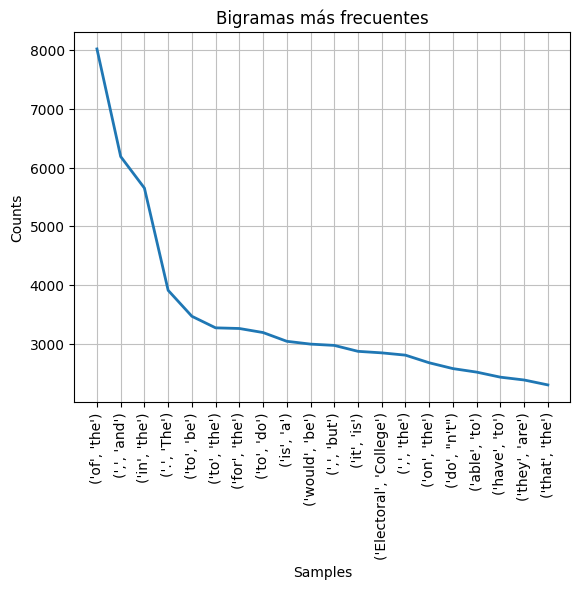

<Axes: title={'center': 'Bigramas más frecuentes'}, xlabel='Samples', ylabel='Counts'>

In [175]:
all_bigrams = [bigram for sublist in data['bigrams'] for bigram in sublist]

# Calcular la frecuencia de los bigramas
bigram_freq = nltk.FreqDist(all_bigrams)

# Graficar los 20 bigramas más frecuentes
bigram_freq.plot(20, title='Bigramas más frecuentes')

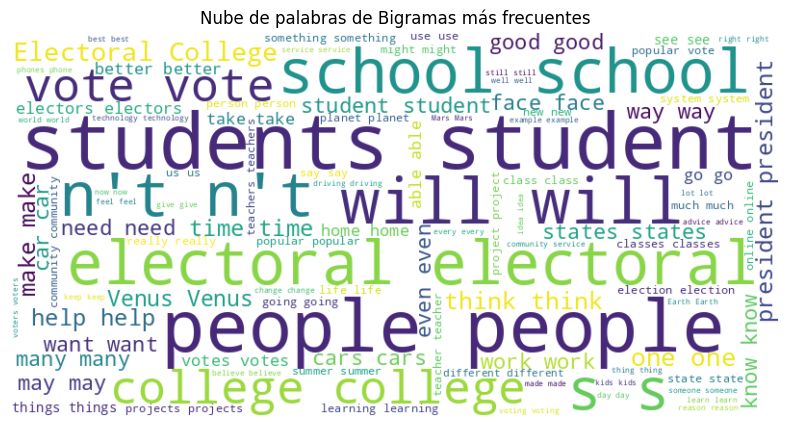

In [176]:
bigrams_text = ' '.join([' '.join(bigram) for bigram in all_bigrams])

# Crear una nube de palabras de los bigramas más frecuentes
wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(bigrams_text)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de palabras de Bigramas más frecuentes')
plt.show()

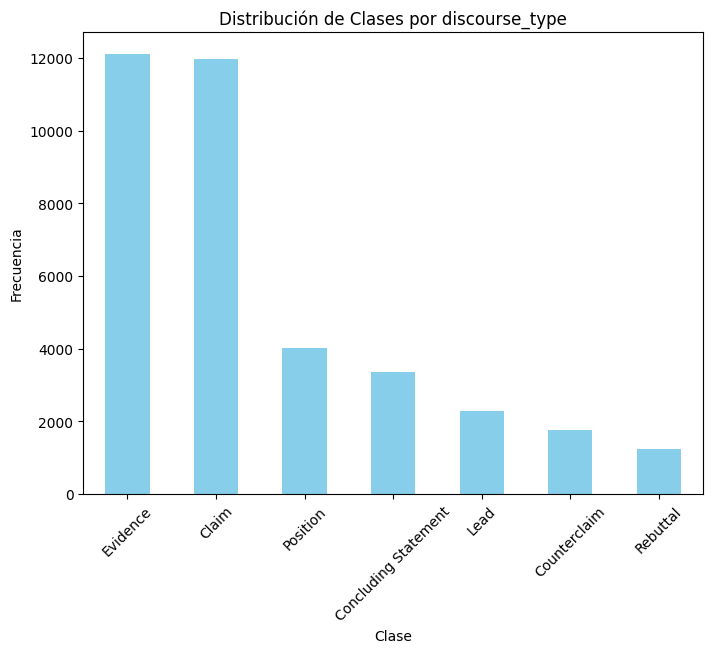

In [177]:
class_counts = data['discourse_type'].value_counts()
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Distribución de Clases por discourse_type')
plt.xlabel('Clase')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()

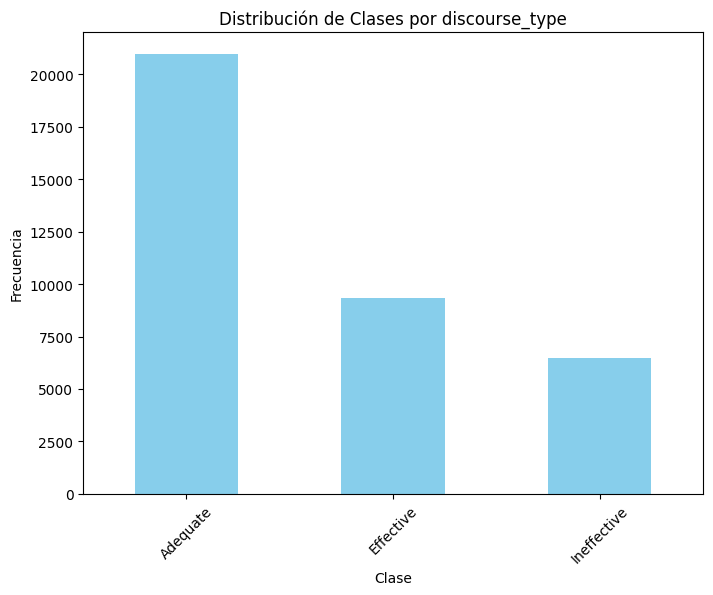

In [178]:
class_counts = data['discourse_effectiveness'].value_counts()
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Distribución de Clases por discourse_type')
plt.xlabel('Clase')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()

## Liempieza de dataset de entreno

Se eliminaran las columnas de *discourse_id* u *essay_id* debido a que estas son solo identificadores no relevantes para el modelo. AL contrario, podrian causar ruido que genere malas predicciones.

Tambien se borran las columnas usadas en en analisis de datos: *tokens* y *bigrams*

In [179]:
data.drop('discourse_id', axis=1, inplace=True)
data.drop('essay_id', axis=1, inplace=True)
data.drop('tokens', axis=1, inplace=True)
data.drop('bigrams', axis=1, inplace=True)
data.head()

,discourse_text,discourse_type,discourse_effectiveness,text_lenght
0,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate,317
1,"On my perspective, I think that the face is a ...",Position,Adequate,210
2,I think that the face is a natural landform be...,Claim,Adequate,105
3,"If life was on Mars, we would know by now. The...",Evidence,Adequate,362
4,People thought that the face was formed by ali...,Counterclaim,Adequate,101


## Capa de inscrustamiento



In [180]:
data['discourse_text']

0        Hi, i'm Isaac, i'm going to be writing about h...
1        On my perspective, I think that the face is a ...
2        I think that the face is a natural landform be...
3        If life was on Mars, we would know by now. The...
4        People thought that the face was formed by ali...
                               ...                        
36760    For many people they don't like only asking on...
36761    also people have different views and opinions ...
36762    Advice is something that can impact a persons ...
36763    someone can use everything that many people sa...
36764    In conclusion asking for an opinion can be ben...
Name: discourse_text, Length: 36765, dtype: object

In [181]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenizar las frases
tokenizador = Tokenizer()
tokenizador.fit_on_texts(data['discourse_text'])
secuencias = tokenizador.texts_to_sequences(data['discourse_text'])

# Rellenar (Pad) las secuencias para que tengan la misma longitud
seceucias = pad_sequences(secuencias, padding='post')
pd.DataFrame(secuencias).head()

# Dimensiones de entrada y salida de la capa de inscrustamiento
long_vocab = len(tokenizador.word_index) + 1
dim_incrustamiento = 2  # Representar cada palabra por un vector 2D

,0,1,2,3,4,5,6,7,8,9,...,836,837,838,839,840,841,842,843,844,845
0,3877,491.0,14008.0,491.0,123.0,2.0,12.0,952.0,59.0,69.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,17,85.0,1188.0,18.0,58.0,6.0,1.0,92.0,8.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,18,58.0,6.0,1.0,92.0,8.0,3.0,343.0,300.0,28.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,24,120.0,50.0,17.0,155.0,30.0,22.0,78.0,42.0,160.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,23,398.0,6.0,1.0,92.0,50.0,1189.0,42.0,7603.0,28.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Split de Datos

In [182]:
y = data['discourse_effectiveness']
X = data.copy()
X.drop('discourse_effectiveness', axis=1, inplace=True)

In [183]:
from sklearn.model_selection import train_test_split

# Dividir los datos en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [184]:
from tensorflow.keras.preprocessing import sequence

X_train = sequence.pad_sequences(X_train, maxlen = 80)
X_test = sequence.pad_sequences(X_test, maxlen = 80)

ValueError: ignored

## Modelo

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM

modelo = Sequential()
modelo.add(Embedding(20000, 128))
modelo.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
modelo.add(Dense(1, activation='sigmoid'))
modelo.summary()

In [ ]:
modelo.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
modelo.fit(
    X_train,
    y_train,
    batch_size = 32,
    epochs = 15,
    verbose = 2,
    validation_data = (X_test, y_test)
)

In [ ]:
X_train